<a href="https://colab.research.google.com/github/CobaMasa/PythonKerasDeeplearning/blob/main/chapter5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter5: Deep Learning for Computer Vision
Contents:
- Overview of CNN
- How to handle overfitting problems
    - Data augmentation
    - Using a pre-trained CNN
    - Fine-tuning pre-trained model
- Visualization of what CNN learned from data & how it decided to the conclusion.

## - How to handle overfitting problems
### Using a pre-trained CNN

In [11]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
display(conv_base.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

None

In [2]:
# List 5-17: Feature extraction with pre-trained CNN
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = 'drive/My Drive/Study/PythonKeras/data/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1/255.)
batch_size=20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode='binary')
    
    i = 0
    for input_batch, labels_batch in generator:
        feature_batch = conv_base.predict(input_batch)
        features[i * batch_size: (i+1) * batch_size] = feature_batch
        labels[i*batch_size: (i+1)*batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
# reshape data to adjust for dense layers
train_features = train_features.reshape(len(train_features), -1)
validation_features = validation_features.reshape(len(validation_features), -1)
test_features = test_features.reshape(len(test_features), -1)

In [ ]:
# List 5-18: Define fully connected layer and train it (fix it with the notation of functional API)
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model

inputs = Input(shape=train_features.shape[1])
x = Dense(256, activation='relu')(inputs)
x = Dropout(0.5)(x)
prediction = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=prediction)
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_features, train_labels,epochs=30, batch_size=20,
                    validation_data=(validation_features, validation_labels))

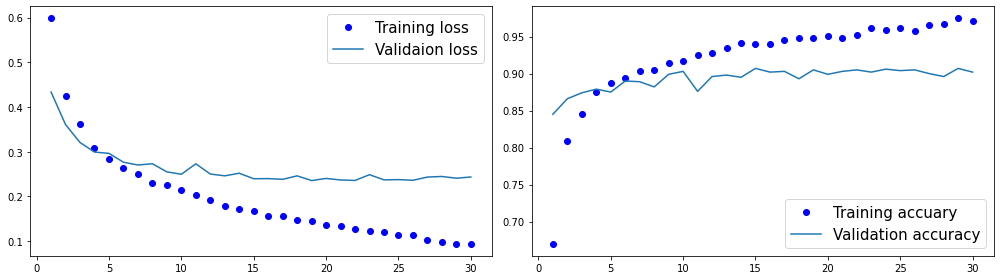

In [37]:
# List 5-19: Plotting the results
import matplotlib.pyplot as plt
n_epochs = range(1, 31)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(n_epochs, train_loss, 'bo', label='Training loss')
ax[0].plot(n_epochs, val_loss, label='Validaion loss')
ax[0].legend(fontsize=15)

ax[1].plot(n_epochs, train_acc, 'bo', label='Training accuary')
ax[1].plot(n_epochs, val_acc, label='Validation accuracy')
ax[1].legend(fontsize=15)
plt.tight_layout()
plt.show();